## Made by Moiseev E., Nasedkin A.

## Used materials...

In [1]:
import numpy as np
import re
import os
import pickle
import logging

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from pymystem3 import Mystem

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA

## Data

In [2]:
total = 0
for cur_root, dirs, files in os.walk('articles'):
    if not dirs:
        total += len(os.listdir(cur_root))
        print('%s: %s' %(cur_root.replace('articles/', ''), len(os.listdir(cur_root))))
print("\nВсего: %s" % total)

Афиша/Выставки и музеи: 427
Афиша/Кино: 1122
Афиша/Книги: 190
Афиша/Концерты: 1223
Афиша/События и места: 1193
Афиша/Театр: 676
Звёзды/Звёздные истории: 251
Звёзды/Интервью: 587
Звёзды/Прямая речь: 252
Звёзды/Светская хроника: 429
Звёзды/Частная жизнь: 723
Здоровая жизнь/Здоровье: 179
Здоровая жизнь/Красота: 91
Здоровая жизнь/Психология: 84
Здоровая жизнь/Путешествия: 144
Здоровая жизнь/Рецепты: 306
Кино/За кадром: 121
Кино/Кинообзоры: 500
Кино/Кинохиты: 75
Кино/Премьеры: 225
Кино/События: 44
Мода/Звёздный стиль: 153
Мода/Тренды: 217
Сериалы/За кадром: 36
Сериалы/Зарубежные сериалы: 34
Сериалы/Интервью: 173
Сериалы/Популярные сериалы: 138
Телевидение/За кадром: 139
Телевидение/Рекомендации: 339

Всего: 10071


## Regular expressions, constants, so on...

In [3]:
np.random.seed(6778)

html = re.compile(r'</?\w+[^>]*>')
quotes_escaped_symbols = re.compile(r'[«»"]|(&\w+;)')
link = re.compile('(https?://)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)')
numbers = re.compile(r'^\d+$')
stop_words = set(stopwords.words('russian')).union(set(stopwords.words('english')))
tokenizer = RegexpTokenizer('\w+')
mystem = Mystem()

## Preprocessing and data-collector

In [4]:
def preprocess_text(text, do_lemmatize=True):
    clean_text = link.sub('', quotes_escaped_symbols.sub('', html.sub('', text.lower())))

    words = [w for w in tokenizer.tokenize(clean_text)]
    if do_lemmatize:
        words = mystem.lemmatize(' '.join(words))

    words = [w for w in words if w.strip() and not numbers.match(w) and w not in stop_words]

    return words


def collect_data(root_dir, do_lemmatize=True, from_file=True):
    if from_file:
        with open('articles.%spkl' % ('lemmatized.' if do_lemmatize else ''), mode='rb') as art_pkl:
            dump = pickle.load(art_pkl)
            X, y = dump[0], dump[1]
    else:
        X = []
        y = []
        for cur_root, dirs, files in os.walk(root_dir):
            if not dirs:
                l = os.path.split(os.path.split(cur_root)[0])[1]
                for f in files:
                    with open(os.path.join(cur_root, f), encoding='cp1251') as tf:
                        X.append(preprocess_text(tf.read(), do_lemmatize))
                        y.append(l)
                        print(len(X))

        with open('articles.%spkl' % ('lemmatized.' if do_lemmatize else ''), mode='wb') as art_pkl:
            pickle.dump([X, y], art_pkl)

    X, y = shuffle(X, y)
    distinct_l = list(sorted(set(y)))
    y = np.array([distinct_l.index(l) for l in y])

    return X, y

## LDA model

In [5]:
def get_lda_model(corpus, num_topics, from_file=True):
    if from_file:
        return LdaModel.load('ldamodel_%s.serialized' % num_topics)

    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

    # turn our tokenized documents into a id <-> term dictionary
    id2word = Dictionary(corpus)

    # convert tokenized documents into a document-term matrix
    corpus = [id2word.doc2bow(text) for text in corpus]

    # generate LDA model
    lda = LdaModel(corpus, num_topics=num_topics, id2word=id2word, passes=20)
    lda.save('ldamodel_%s.serialized' % num_topics)

    print(lda.print_topics(num_topics=num_topics, num_words=4))

    return lda

## Doc2vec model

In [6]:
def get_doc2vec_model(docs, dim, n_epochs, from_file=True):
    if from_file:
        return Doc2Vec.load('doc2vec_%s.serialized' % dim)

    tagged_docs = [TaggedDocument(w_list, str(index)) for index, w_list in enumerate(docs)]
    doc2vec = Doc2Vec(tagged_docs, dm=0, alpha=0.025, size=dim, min_alpha=0.025, min_count=0)

    for epoch in range(n_epochs):
        if epoch % 20 == 0:
            print('Training offset: %s' % epoch)

        doc2vec.train(tagged_docs)
        doc2vec.alpha -= 0.002  # decrease the learning rate
        doc2vec.min_alpha = doc2vec.alpha  # fix the learning rate, no decay

    doc2vec.save('doc2vec_%s.serialized' % dim)

    return doc2vec

## Transformations to model spaces

In [7]:
def transform_to_topic_space(lda, doc):
    """
    :param LdaModel lda:
    :param list     doc:
    """
    res = np.zeros((lda.num_topics,))

    for item in lda[lda.id2word.doc2bow(doc)]:
        ind, val = item
        res[ind] = val

    return res


def transform_to_doc2vec_space(doc2vec, doc):
    """
    :param Doc2Vec doc2vec:
    :param list    doc:
    """
    return doc2vec.infer_vector(doc)

## Transformation example

In [8]:
text = """<h1>Кирил Бонфильоли «Трилогия о Чарли Маккабрее»</h1> 
<h2 >Мы уже писали о книге &laquo;Не тычьте в меня этой штукой&raquo;, по мотивам которой был снят фильм &laquo;Мордекай&raquo; с Джонни Деппом в главной роли. В свет вышли еще две книги о приключениях главного героя &mdash; прохиндея, гедониста и сноба Чарли Маккабрея &mdash; &laquo;Что-то гадкое в сарае&raquo; и &laquo;После вас с пистолетом&raquo;. </h2> 
Каждая снабжена объяснением, почему переводчик решил фамилию Mortdecai заменить на Маккабрей. Полные юмора и неожиданных поворотов детективы понравятся всем поклонникам хороших книг. К тому же удобный мини-формат и яркие обложки сделают их прекрасным подарком. Чарли Маккабрей чего только не делает: попадает в китайские спецслужбы и разыскивает преступника в резиновой маске, изучает поверья о бессмертной жабе и охотится за похищенной картиной Гойи, женится на неприлично богатой женщине и даже пытается убить королеву&hellip; Приключения обаятельного авантюриста не оставят вас равнодушными, ведь этими книжками восхищается сам Стивен Фрай. 
<br /> 
<b>Издательство: </b>LiveBook 
<br />"""
text = preprocess_text(text)

print(transform_to_topic_space(get_lda_model([], 50), text))
print(transform_to_doc2vec_space(get_doc2vec_model([], 50, 0), text))

[ 0.          0.0282104   0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.0902852   0.          0.          0.          0.          0.          0.
  0.02198743  0.07187455  0.          0.          0.          0.          0.
  0.          0.          0.28107806  0.          0.          0.12419741
  0.          0.16038164  0.          0.          0.04824802  0.          0.
  0.          0.          0.          0.06881175  0.0966781   0.          0.
  0.          0.        ]
[ 0.04042683 -0.00725855  0.04438538 -0.7658177  -0.12154498  0.17719774
  0.00412133 -0.10924144 -0.72537935  0.1070536  -0.09482865  0.29258513
 -0.3401767  -0.38638836  0.57924229 -0.22158639  0.09797563 -0.11420164
  0.04358135  1.02251136  0.13702598 -0.25634071  0.21461074  0.22687641
 -0.3577829   0.017625   -0.38320354 -0.0231499  -0.77986574 -0.1837354
  0.19092184  0.24339448 -0.33039358 -0.21374562  0.80426586  0.28828442
  

## Evaluation

In [9]:
def evaluate_models(dim, from_file=True, plot=True):
    X, y = collect_data('articles', from_file)

    lda = get_lda_model(X, dim, from_file)
    doc2vec = get_doc2vec_model(X, dim, 100, from_file)

    for model in [lda, doc2vec]:
        if isinstance(model, LdaModel):
            fit_X = [transform_to_topic_space(model, x) for x in X]
        else:
            fit_X = [transform_to_doc2vec_space(model, x) for x in X]

        cls = KMeans(n_clusters=len(set(y)))
        cls.fit(fit_X)

        pred_y = cls.labels_
        print('%s\nn_clusters=%s\nnormalized_mutual_info_score: %s\nadjusted_mutual_info_score: %s' % (
            type(model).__name__,
            cls.n_clusters,
            normalized_mutual_info_score(y, pred_y),
            adjusted_mutual_info_score(y, pred_y)
        ))

        if plot:
            pca = PCA(n_components=2)
            reduced_data = pca.fit_transform(fit_X)
            # Percentage of variance explained for each components
            print('explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))

            plt.figure()
            for color, i in zip('bgrcmyk', range(cls.n_clusters)):
                plt.scatter(reduced_data[y == i, 0], reduced_data[y == i, 1],
                            color=color, s=10, alpha=.8, lw=2, label=i)
            plt.legend(loc='best', shadow=False, scatterpoints=1)
            plt.title('True labels\nPCA of %s' % type(model).__name__)

            plt.figure()
            for color, i in zip('bgrcmyk', range(cls.n_clusters)):
                plt.scatter(reduced_data[pred_y == i, 0], reduced_data[pred_y == i, 1],
                            color=color, s=10, alpha=.8, lw=2, label=i)
            plt.legend(loc='best', shadow=False, scatterpoints=1)
            plt.title('Predicted labels\nPCA of %s' % type(model).__name__)

            plt.show()

## \__main__

LdaModel
n_clusters=7
normalized_mutual_info_score: 0.33169709544
adjusted_mutual_info_score: 0.303870740178
explained variance ratio (first two components): [ 0.22041906  0.14119971]


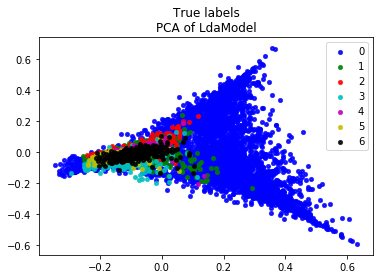

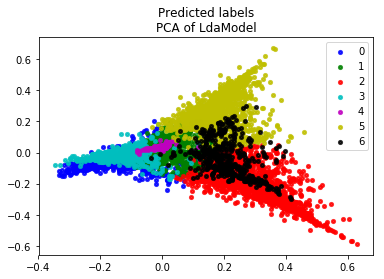

Doc2Vec
n_clusters=7
normalized_mutual_info_score: 0.494911145844
adjusted_mutual_info_score: 0.470068404032
explained variance ratio (first two components): [ 0.12115182  0.10171134]


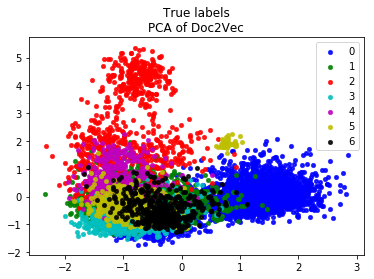

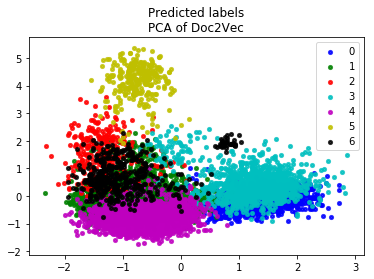

In [10]:
evaluate_models(dim=50, from_file=True, plot=True)